In [1]:
import numpy as np
import matplotlib.pyplot as plt
from AWG_function import *

In [2]:
inst=connect_PXI()

Load TEProteus.dll from : C:\Windows\system32\TEProteus.dll
connected to: Tabor Electronics,P9484M,000002243278,1.237.0 --slot#: 8,


In [3]:
#wavefore parameters
max_dac=65535 # Max Dac
half_dac=max_dac/2 # DC Level
data_type = np.uint16 # DAC data type
onLen = 32 * 20 # Pulse on time multiple of 32 or 28ns
segTime = onLen / (SampleRateDAC_IQ)
print('On time')
print(segTime)
dacWaveOn_I = np.ones(onLen)
dacWaveOn_I = dacWaveOn_I * max_dac
dacWaveOn_I = dacWaveOn_I.astype(data_type)
dacWaveOn_Q = dacWaveOn_I
# reshapes for IQIQIQIQIQ....
arr_tuple = (dacWaveOn_I, dacWaveOn_Q)
dacWaveOn_IQ = np.vstack(arr_tuple).reshape((-1,), order='F')
offLen = 32
dacWaveOff_I = np.ones(offLen)
dacWaveOff_I = dacWaveOff_I * half_dac
dacWaveOff_I = dacWaveOff_I.astype(data_type)
dacWaveOff_Q = dacWaveOff_I
# reshapes for IQIQIQIQIQ....
arr_tuple = (dacWaveOff_I, dacWaveOff_Q)
dacWaveOff_IQ = np.vstack(arr_tuple).reshape((-1,), order='F')
################################################################################
#AWG channel
ch = 1 # everythinf after relates to CH 1
cmd = ':INST:CHAN {0}'.format(ch)
inst.send_scpi_cmd(cmd)
cmd = ':FREQ:RAST {0}'.format(2.5E9) # force to max 16 bit DAC
inst.send_scpi_cmd(cmd)
inst.send_scpi_cmd(':INIT:CONT OFF')
inst.send_scpi_cmd(':TRAC:DEL:ALL')
inst.send_scpi_cmd(':TRIG:SOURce:ENAB {}'.format('TRG1'))
inst.send_scpi_cmd(':TRIG:SELECT {}'.format('TRG1'))
inst.send_scpi_cmd(':TRIG:LTJ ON')
inst.send_scpi_cmd(':TRIG:LEV 0.5')
inst.send_scpi_cmd(':TRIG:DEL 0E-9')
inst.send_scpi_cmd(':TRIG:SLOP POS')
inst.send_scpi_cmd(':TRIG:COUP OFF')
inst.send_scpi_cmd(':TRIGger:STAT ON')
resp = inst.send_scpi_query(':SYST:ERR?')
print("End of trig Error = ")
print(resp)
################################################################################
# Define segment memory
segnum = 1
cmd = ':TRAC:DEF {0}, {1}'.format(segnum, len(dacWaveOn_IQ))
inst.send_scpi_cmd(cmd)
# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd(cmd)
# Increase the timeout before writing binary-data:
inst.timeout = 30000
# Send the binary-data with *OPC? added to the beginning of its prefix.
inst.write_binary_data('*OPC?; :TRAC:DATA', dacWaveOn_IQ)
# Set normal timeout
inst.timeout = 10000
resp = inst.send_scpi_query(':SYST:ERR?')
print("Trace Download Error = ")
print(resp)
# Define segment memory
segnum = 2
cmd = ':TRAC:DEF {0}, {1}'.format(segnum, len(dacWaveOff_IQ))
inst.send_scpi_cmd(cmd)
# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
inst.send_scpi_cmd(cmd)
# Increase the timeout before writing binary-data:
inst.timeout = 30000
# Send the binary-data with *OPC? added to the beginning of its prefix.
inst.write_binary_data('*OPC?; :TRAC:DATA', dacWaveOff_IQ)
# Set normal timeout
inst.timeout = 10000
resp = inst.send_scpi_query(':SYST:ERR?')
print("Trace Download Error = ")
print(resp)
################################################################################
cmd = ':SOUR:MODE DUC'
resp = inst.send_scpi_cmd(cmd)
cmd = ':SOUR:INT X8'
resp = inst.send_scpi_cmd(cmd)
cmd = ':SOUR:IQM ONE'
resp = inst.send_scpi_cmd(cmd)
sampleRateDACInt = SampleRateDAC_IQ * 8
print('Interpolated Sample Clk Freq {0}'.format(sampleRateDACInt))
cmd = ':FREQ:RAST {0}'.format(sampleRateDACInt)
resp = inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("IQ Set Error = ")
print(resp)
cmd = ':SOUR:NCO:CFR1 {0}'.format(10E6)
resp = inst.send_scpi_cmd(cmd)
print('NCO CF: {0}'.format(10E6))

On time
6.4e-07
End of trig Error = 
0, no error
Trace Download Error = 
0, no error
Trace Download Error = 
0, no error
Interpolated Sample Clk Freq 8000000000.0
IQ Set Error = 
0, no error
NCO CF: 10000000.0


In [3]:
ext_trigger_source=np.array([1,1,0,0])
carrier_frequency=np.array([10E6,10E6,10E6,10E6])
configurate_all_DAC(inst=inst,ext_trigger_source_DAC=ext_trigger_source,carrier_frequency=carrier_frequency)

DAC sample rate 1.0GS/s, SCLK 8.0GS/s
DAC minimun segment length 32.0ns, segment granuality 16.0ns
DAC configuration successful


In [4]:
configurate_all_trigger(inst=inst)

trigger configuration successful


In [5]:
pulse_1ns=segment(address={'inst':inst,'channel':1,'segment':1})

In [6]:
pulse_1ns.default_pulse(length=4800,amplitude=0.5,phase=0,type='sine')

In [7]:
pulse_1ns.compile_and_download_segment()

channel 1, segment 1 downloaded


In [8]:
ch1_task=task_table(address={'inst':inst,'channel':1},length=1)

In [9]:
ch1_task.new_task(tasknum=1,segnum=1,ext_trigger_ch=1,digitizer_trigger=True,next_task=1)

In [10]:
ch1_task.download_task_table()

channel 1 task table downloaded


In [36]:
ch1_digitizer=digitizer(address={'inst':inst,'channel':1},task_trigger_channel=1,carrier_frequency=10E6,numframes=1,framelen=4800)

digitizer sample rate 2.0GS/s, SCLK 0.125GS/s
digitizer granularity 384.0ns
Channel 1 aquisition frame Length 1.92e-05, frame number 1


In [39]:
ch1_digitizer.inquire_acquisition()

(0, 0)

In [40]:
ch1_digitizer.read_digitizer_data()

Total read size in bytes: 19200
acquired 2400 complex points


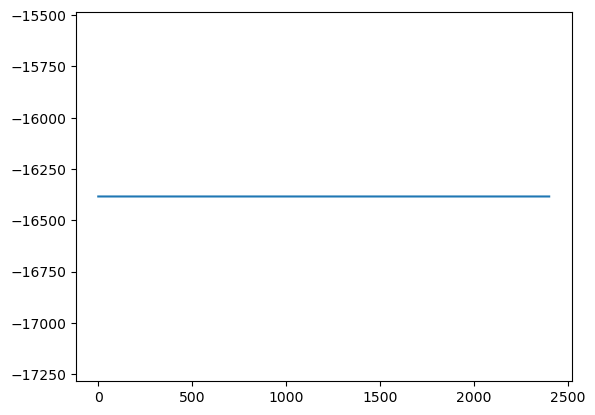

In [41]:
plt.plot(ch1_digitizer.wavI)

In [12]:
numframes, framelen = 3, 4800 # remember multiple of 96
totlen = numframes * framelen
print('Waveform Length {0}'.format(totlen))
wav1 = np.zeros(totlen, dtype=np.uint32)
sampleRateADC = SampleRateADC
cmd = ':DIG:MODE DUAL'
inst.send_scpi_cmd(cmd)
print('ADC Clk Freq {0}'.format(sampleRateADC))
cmd = ':DIG:FREQ  {0}'.format(sampleRateADC)
inst.send_scpi_cmd(cmd)
print('Aquisition Length {0}'.format(framelen/2/sampleRateADC*16)) # x16 decimation
resp = inst.send_scpi_query(':DIG:FREQ?')
print("Dig Frequency = ")
print(resp)
# Enable capturing data from channel 1
cmd = ':DIG:CHAN:SEL 1'
inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("Dig error = ")
print(resp)
cmd = ':DIG:DDC:MODE COMP'   # DDC activation to complex i+jq
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:CFR1 {0}'.format(10E6)
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:PHAS1 0'
inst.send_scpi_cmd(cmd)
cmd = ':DIG:DDC:CLKS AWG'
rc = inst.send_scpi_cmd(cmd)
resp = inst.send_scpi_query(':SYST:ERR?')
print("Set complex error = ")
print(resp)
cmd = ':DIG:CHAN:STATE ENAB'
inst.send_scpi_cmd(cmd)
# trigger from the task list
cmd = ':DIG:TRIG:SOURCE TASK1'
inst.send_scpi_cmd(cmd)
dig_system_delay=560E-9
cmd=':INST:CHAN:SEL 1'
inst.send_scpi_cmd(cmd)
# need to set the delay for individual output channel
cmd = ':DIG:TRIG:AWG:TDEL {0}'.format(dig_system_delay)
inst.send_scpi_cmd(cmd)
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)
# Select the frames for the capturing
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)

Waveform Length 14400
ADC Clk Freq 2000000000.0
Aquisition Length 1.92e-05
Dig Frequency = 
2000000000.000
Dig error = 
0, no error
Set complex error = 
0, no error


0

In [13]:
import time
inst.send_scpi_cmd(':DIG:INIT OFF')

inst.send_scpi_cmd(':DIG:INIT ON')

cmd = '*TRG'

inst.send_scpi_cmd(cmd)

 

frameRx = 0

times = 0

while (frameRx != 1):

    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')

    framesParam = resp.split(",")

    frameRx = int(framesParam[1])

    times += 1

    time.sleep(0.1)

    # if times > 100:

    #     break

    #     # end time and print time

    print(resp)

inst.send_scpi_cmd(':DIG:INIT OFF')

1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0


KeyboardInterrupt: 